In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

D:\financial_time_series\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [3]:
data = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)

data.sort_index(inplace=True)

def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

data = create_features(data)

df_prophet = data[['closePrice']].reset_index()
df_prophet.rename(columns={'startTime': 'ds', 'closePrice': 'y'}, inplace=True)

22:55:01 - cmdstanpy - INFO - Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 37 days  1.774185e+08  13319.854637  10562.657585  0.348053  0.404088   
1 38 days  1.807990e+08  13446.153448  10707.096927  0.352833  0.405379   
2 39 days  1.838455e+08  13558.962842  10845.606174  0.357452  0.411473   
3 40 days  1.868633e+08  13669.796910  10996.888796  0.362728  0.419225   
4 41 days  1.895167e+08  13766.505155  11134.955886  0.367690  0.424205   

      smape  coverage  
0  0.377177  0.407407  
1  0.383938  0.398148  
2  0.390656  0.388889  
3  0.397853  0.379630  
4  0.404490  0.370370  


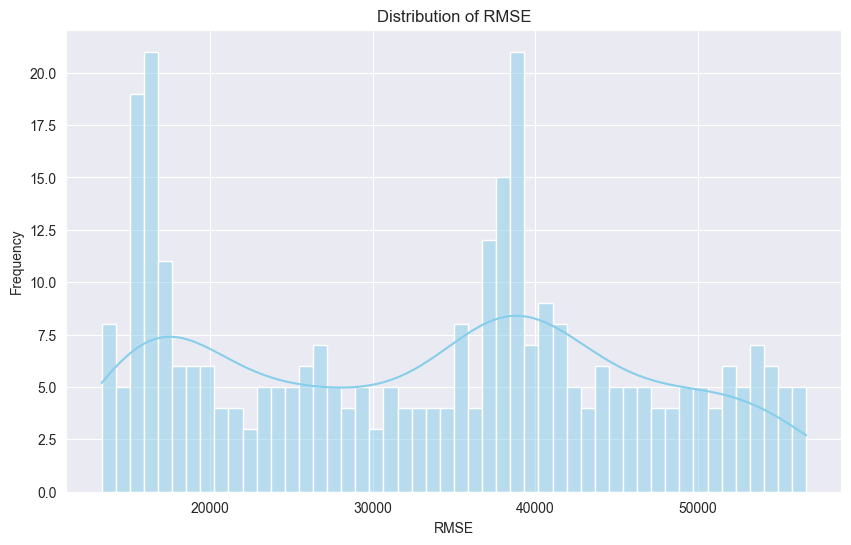

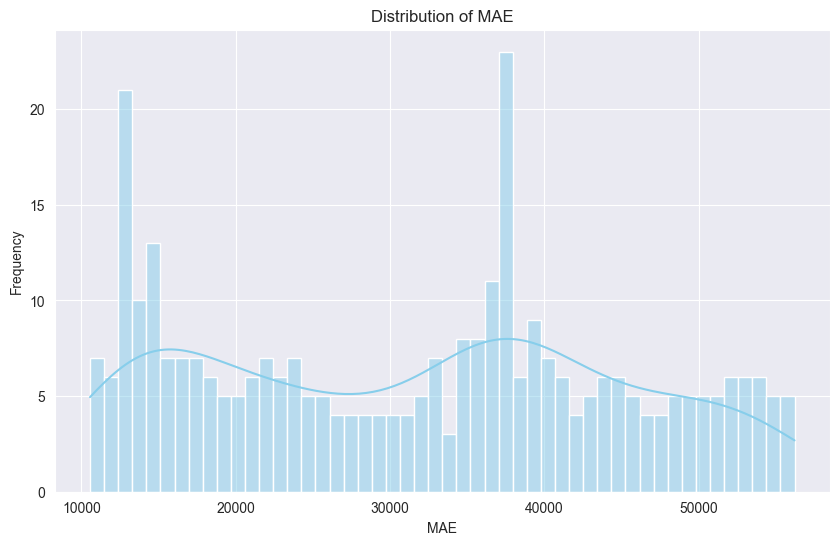

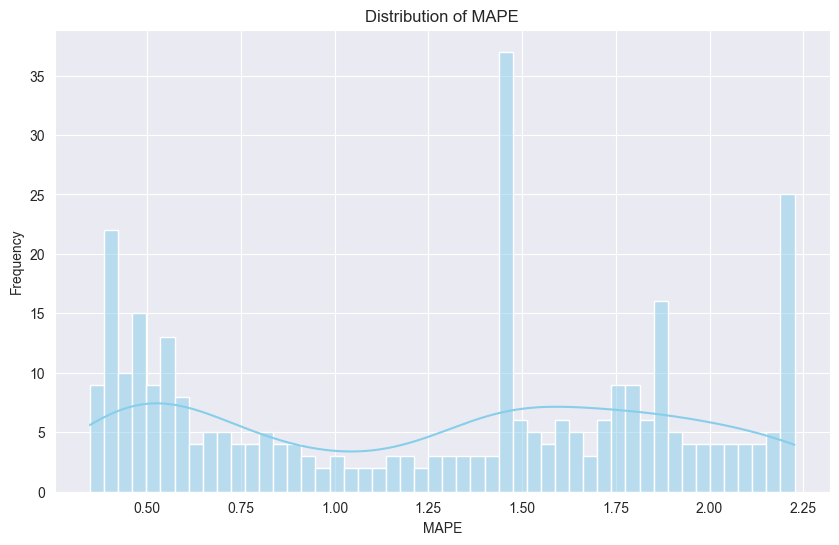

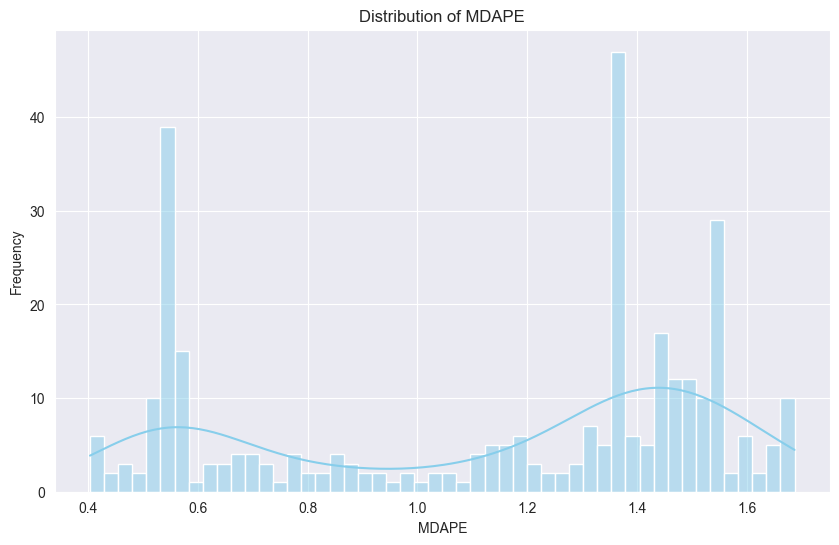

In [4]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

df_cv = cross_validation(model,
                         initial='1095 days',  # начальный тренировочный период (3 года)
                         period='180 days',    # промежуток между началом новых тренировочных периодов
                         horizon='365 days',   # прогнозируемый горизонт (1 год)
                         parallel="processes") # использование параллельных процессов для ускорения

df_p = performance_metrics(df_cv)
print(df_p.head())

metrics = ['rmse', 'mae', 'mape', 'mdape']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_p[metric], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {metric.upper()}')
    plt.xlabel(metric.upper())
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [5]:
future = model.make_future_dataframe(periods=365)  # Прогноз на 365 дней вперёд
forecast = model.predict(future)

test_period = 365
df_test = df_prophet[-test_period:]
predictions = forecast[['ds', 'yhat']].set_index('ds').loc[df_test['ds']]

In [6]:
mse = mean_squared_error(df_test['y'], predictions['yhat'])
rmse = mean_squared_error(df_test['y'], predictions['yhat'])
mae = mean_absolute_error(df_test['y'], predictions['yhat'])
try:
    # Если используете sklearn >= 0.24
    mape = mean_absolute_percentage_error(df_test['y'], predictions['yhat']) * 100
except AttributeError:
    # Альтернативная реализация, если mean_absolute_percentage_error недоступна
    mape = np.mean(np.abs((df_test['y'] - predictions['yhat']) / df_test['y'])) * 100
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Prophet Модель - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 14569300.7948
Root Mean Squared Error (RMSE): 14569300.7948
Mean Absolute Error (MAE): 2608.7057
Prophet Модель - Mean Absolute Percentage Error (MAPE): 916.81%


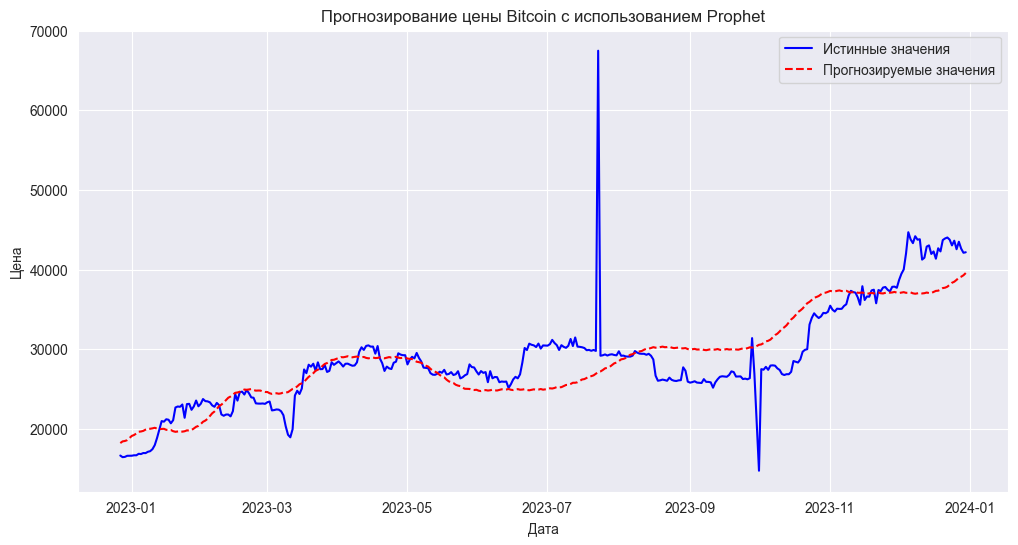

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df_test['ds'], df_test['y'], label='Истинные значения', color='blue')
plt.plot(predictions['yhat'], label='Прогнозируемые значения', color='red', linestyle='--')
plt.title('Прогнозирование цены Bitcoin с использованием Prophet')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

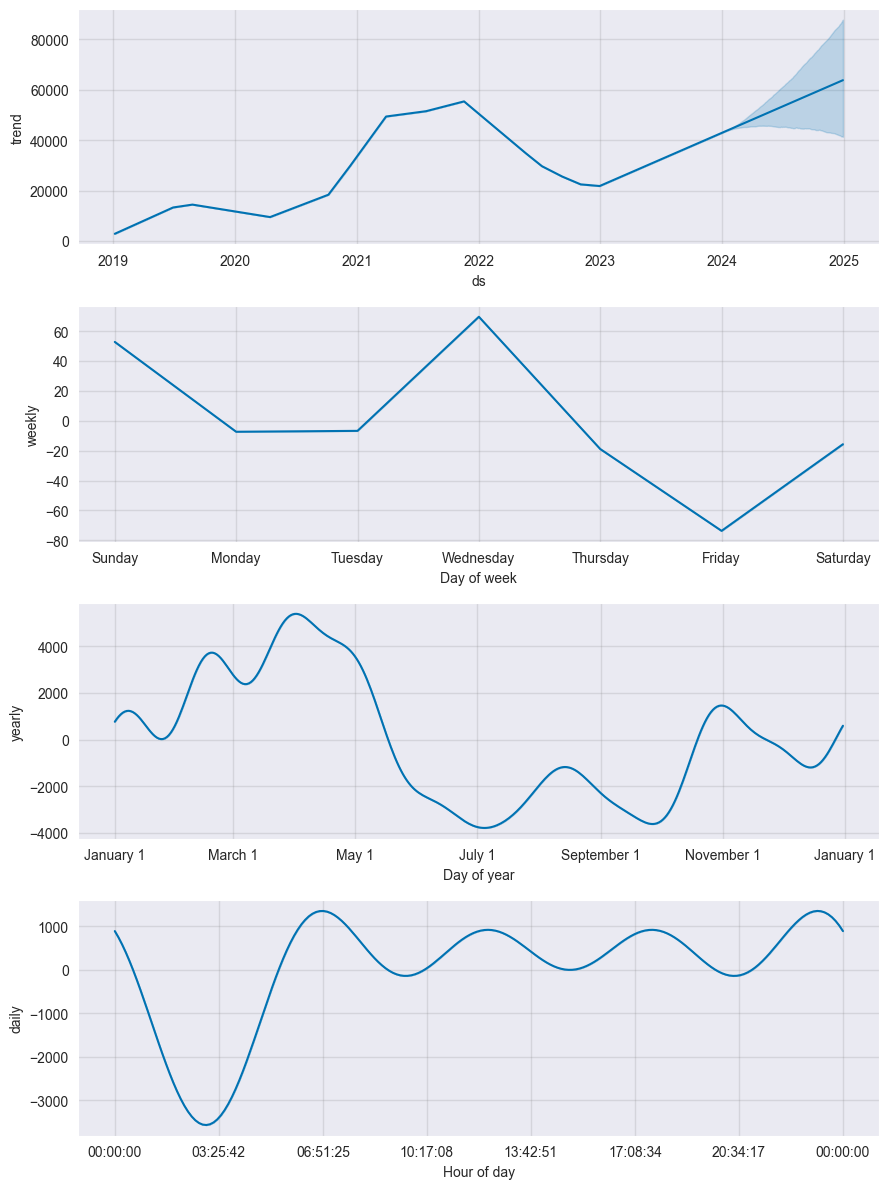

In [8]:
model.plot_components(forecast)
plt.show()

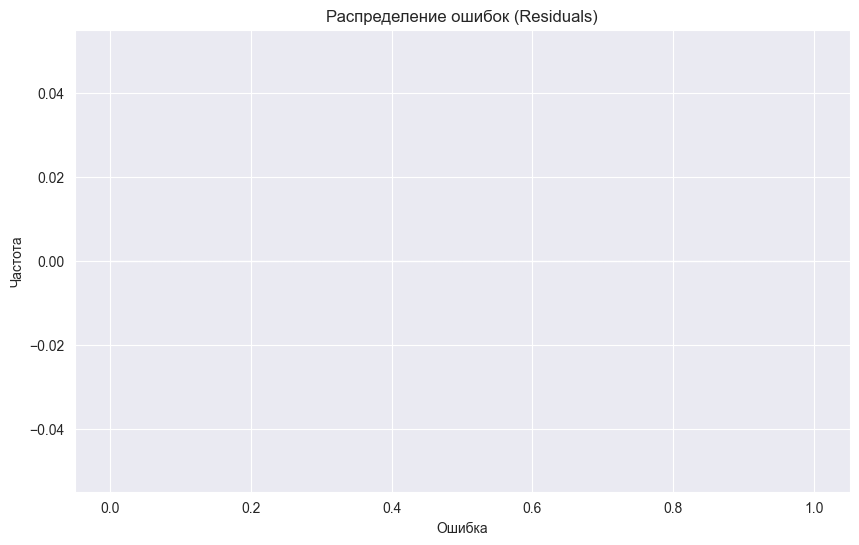

In [9]:
residuals = df_test['y'] - predictions['yhat']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Распределение ошибок (Residuals)')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

D:\financial_time_series\.venv\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
D:\financial_time_series\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


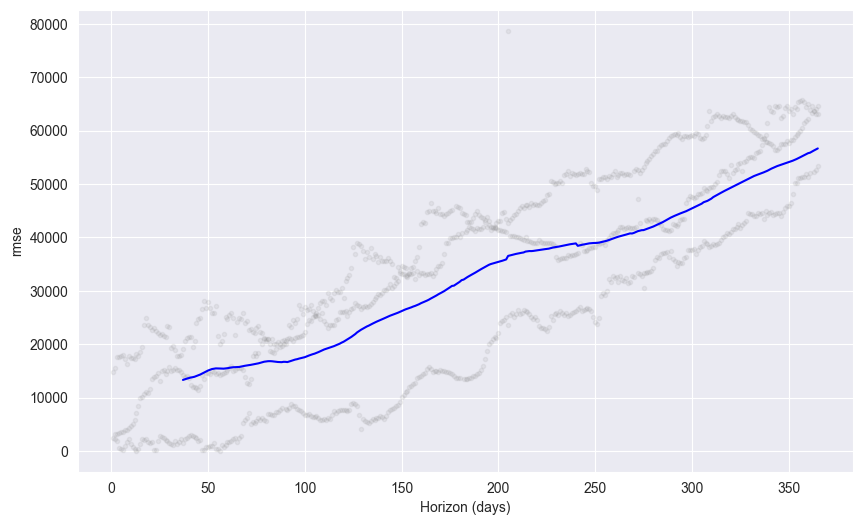

In [10]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

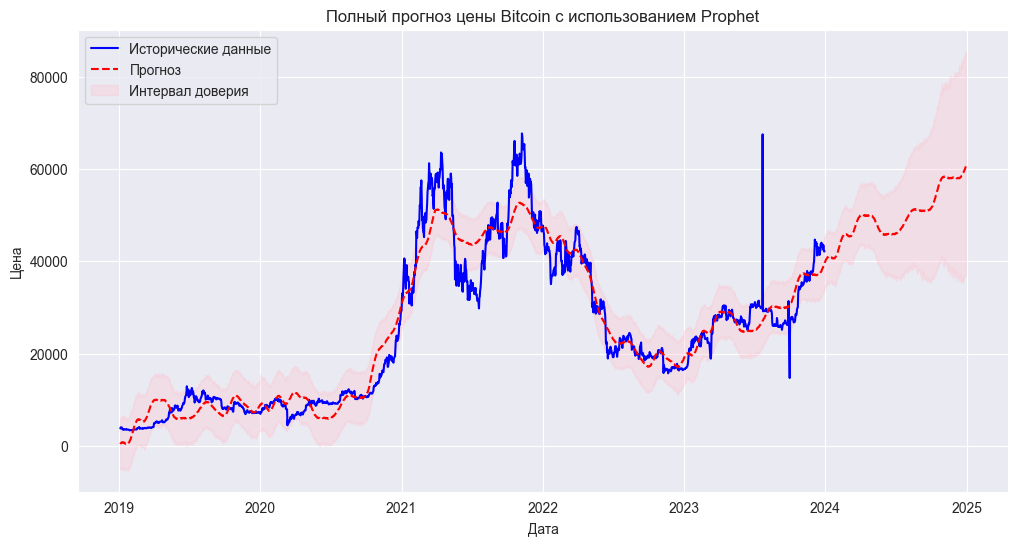

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Исторические данные', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='red', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3, label='Интервал доверия')
plt.title('Полный прогноз цены Bitcoin с использованием Prophet')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()